# Financial Data Analysis
Where is the data from. What do we want to do?

## Imports of Data and reading into Pandas Dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
loan_df = pd.read_excel('../input/personal-loan-modelling/bank-personal-loan-data.xlsx', 1).set_index('ID')
loan_df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


## Description of Columns
|Field|Description|
|-|-|
|ID|Customer ID|
|Age|Customer's age in completed years|
|Experience|#years of professional experience|
|Income|Annual income of the customer|
|ZIPCode|Home Address ZIP code|
|Family|Family size of the customer|
|CCAvg|Avg. spending on credit cards per month|
|Education|Education Level. 1: Professional; 2: Undergrad; 3: Graduate|
|Mortgage|Value of house mortgage if any|
|Personal Loan|Did this customer accept the personal loan offered in the last campaign?|
|Securities Account|Does the customer have a securities account with the bank?|
|CD Account|Does the customer have a certificate of deposit (CD) account with the bank?|
|Online|Does the customer use internet banking facilities?|
|CreditCard|Does the customer use a credit card issued by UniversalBank?|

In [3]:
# Here we resolve the Education column
loan_df.Education = pd.Series(loan_df.Education.replace({1: "Professional", 2: "Undergrad", 3: "Graduate"}), dtype="category")

In [4]:
loan_df.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


As we can see in the "count" row we don't have any missing values. 

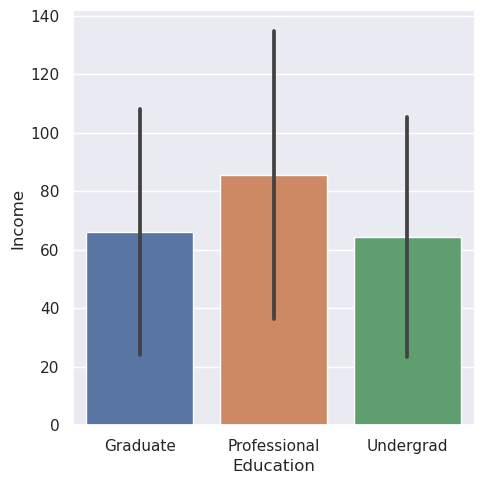

In [5]:
sns.catplot(loan_df, kind="bar", x="Education", y="Income", errorbar="sd")

The height of the bar tells us the mean of the value. The black bar the std deviation. As we can see std deviation on income data is quite high.

<AxesSubplot:>

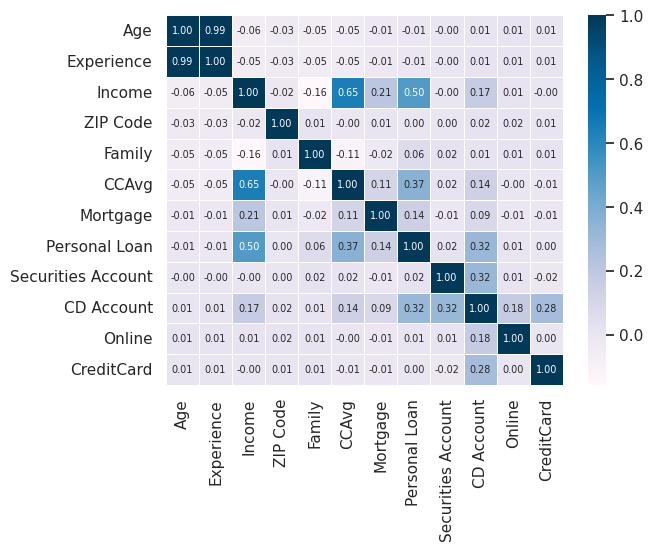

In [6]:
sns.heatmap(loan_df.corr(), annot=True, annot_kws={"size": "xx-small"}, fmt=".2f", cmap='PuBu', linewidths=.5 )